Connecting the Google Colab to Google Drive

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Changing Directory to the path where neural style transfer notebook is stored.

In [3]:
cd "/content/gdrive/MyDrive/DEEP_PROJECTS/NEURAL_STYLE_TRANSFER"

/content/gdrive/MyDrive/DEEP_PROJECTS/NEURAL_STYLE_TRANSFER


Installing Keras for VGG-19 model

In [4]:
!pip install keras

Specifying the path where base and style image is stored.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#style_transfer_url = "https://i.imgur.com/9ooB60I.jpg"
#base_url = "https://tourism.euskadi.eus/contenidos/d_destinos_turisticos/0000004981_d2_rec_turismo/en_4981/images/CT_cabecerabilbaoguggen.jpg"

#For accesing image from link
#style_image_path = tf.compat.v2.keras.utils.get_file(fname = "style.jpg", origin = style_transfer_url)
#For accesing image from google drive
style_image_path = "style.jpg"
#base_image_path = tf.compat.v2.keras.utils.get_file(fname = "main.jpg", origin = base_url)
base_image_path = "base.jpg"

Viewing Image

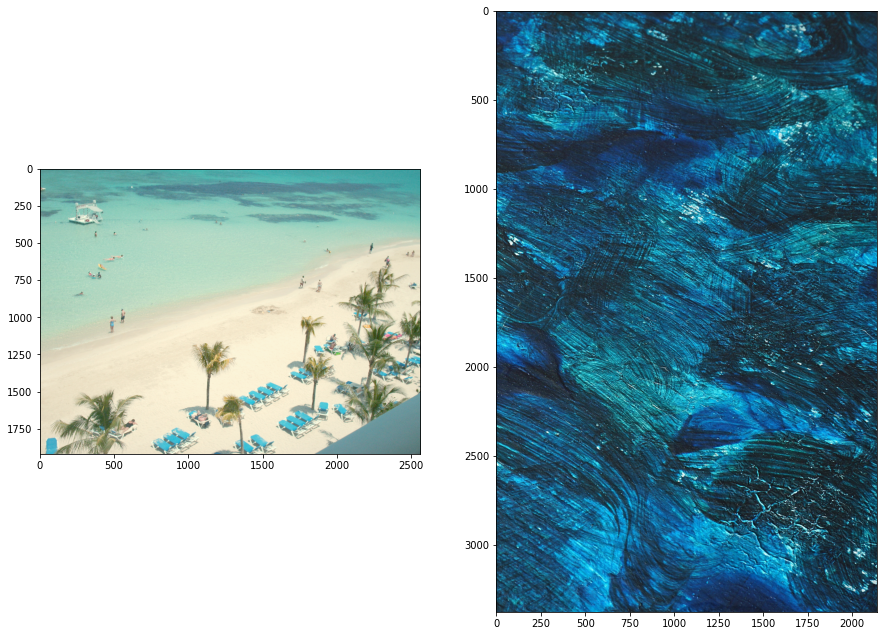

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# read the image file in a numpy array
a = plt.imread(base_image_path)
b = plt.imread(style_image_path)
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(a)
axarr[1].imshow(b)
plt.show()

In [15]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [16]:
def coste_estilo(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [17]:
def coste_contenido(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

Downloading VGG-19 model

In [18]:
from tensorflow.keras.applications import vgg19

model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [19]:
from keras import Model

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [20]:
capas_estilo = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

capas_contenido = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensioner.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Get the values in all the layers for the three images.
    features = feature_extractor(input_tensor)

    #3. Inicializar the loss

    loss = tf.zeros(shape=())

    # 4. Extract the content layers + content loss
    layer_features = features[capas_contenido]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * coste_contenido(
        base_image_features, combination_features
    )
    # 5. Extraer the style layers + style loss
    for layer_name in capas_estilo:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = coste_estilo(style_reference_features, combination_features)
        loss += (style_weight / len(capas_estilo)) * sl

    return loss

In [21]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [22]:
import keras
from tensorflow.keras.applications import vgg19
import numpy as np


def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = tf.compat.v2.keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = tf.compat.v2.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [23]:
def deprocess_image(x):

    # Convertimos el tensor en Array
    x = x.reshape((img_nrows, img_ncols, 3))

    # Hacemos que no tengan promedio 0
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Convertimos de BGR a RGB.
    x = x[:, :, ::-1]

    # Nos aseguramos que están entre 0 y 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x

In [24]:
from datetime import datetime

def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(combination_image.numpy())
  tf.compat.v2.keras.preprocessing.image.save_img(image_name, img)

Setting the Iteration count and number of images to be stored.

In [26]:
width, height = tf.compat.v2.keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

optimizer = tf.compat.v2.keras.optimizers.SGD(
    tf.compat.v2.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 100

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0: # number of times images to be stored
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 100: loss=4385.67


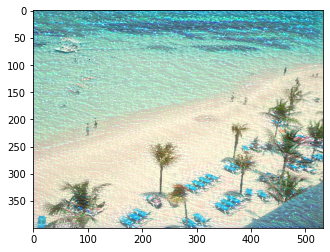

In [28]:
g=plt.imread("100_20220123_173234_image.png")
plt.imshow(g)